In [ ]:
!sudo pip install pingouin

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pingouin as pg
import seaborn as sns
from sklearn.preprocessing import scale

In [ ]:
def read_csv(ano):
    arquivo = f'vendas_linha_petshop_{ano}.csv'
    df = pd.read_csv(arquivo, sep=';',
                          decimal=',',
                          encoding='latin1')
    df['Ano'] = ano
    return df


In [ ]:
df_final = pd.concat([read_csv(2019), read_csv(2020), read_csv(2021), read_csv(2022)], ignore_index=True)

In [ ]:
df_final.head()

,cod_pedido,regiao_pais,produto,valor,quantidade,valor_total_bruto,data,estado,formapagto,centro_distribuicao,responsavelpedido,valor_comissao,lucro_liquido,categoriaprod,Ano
0,1,Norte,Biscoito True Champion 300g,22.0,2.0,44.0,13/06/2019,Acre,Dinheiro,Rapid Pink,Carlos,0.44,17.6,Alimentação,2019
1,2,Norte,Biscoito True Champion 300g,21.0,2.0,42.0,03/01/2019,Amapá,Pix,Rapid Pink,Maria Linda,0.42,16.8,Alimentação,2019
2,3,Norte,Biscoito True Champion 300g,22.0,NaN,44.0,18/01/2019,Pará,Boleto Bancário,Rapid Pink,Julia,0.88,35.2,Alimentação,2019
3,4,Norte,Biscoito True Champion 300g,19.0,4.0,88.0,19/08/2019,Rondônia,Boleto Bancário,Rapid Pink,Yuri,0.76,30.4,Alimentação,2019
4,5,Norte,Biscoito True Champion 300g,22.0,2.0,44.0,18/10/2019,Tocantins,Cartão Crédito,Rapid Pink,Dolores,0.44,17.6,Alimentação,2019


In [ ]:
duplicated = df_final['cod_pedido'].duplicated().to_frame('cod_pedido')
duplicated[duplicated['cod_pedido']==True]

,cod_pedido


Possivel verificar que mesmo juntando tabelas de anos diferentes, não possuimos cod_pedido iguais



---



##Missings values

- Identificando missings values

In [ ]:
missings_linha = pd.DataFrame({'id': df_final['cod_pedido'].tolist(),
                               'n_missings': df_final.isna().sum(axis=1).tolist()})
missings_linha[missings_linha['n_missings'] >= 1]

,id,n_missings
2,3,1
157,158,1
281,282,1
405,406,1
529,530,1
...,...,...
181223,181418,1
181316,181511,1
181409,181604,1
181502,181697,1


In [ ]:
missings_linha[missings_linha['n_missings'] > 1]

,id,n_missings


Podemos observar que em nenhuma das linhas existe mais de um missings, logo é mais interresante observar os missings por coluna

In [ ]:
missings_coluna = pd.DataFrame(df_final.isna().sum().to_frame('n_missings').reset_index().rename(columns={'index': 'variaveis'}))
missings_coluna

,variaveis,n_missings
0,cod_pedido,0
1,regiao_pais,0
2,produto,0
3,valor,0
4,quantidade,520
5,valor_total_bruto,0
6,data,0
7,estado,0
8,formapagto,0
9,centro_distribuicao,0


Aqui conseguimos verificar que só existia um missings por linha por que todos estavam na mesma coluna

In [ ]:
n_linhas = df_final.shape[0]
missings_coluna[missings_coluna['variaveis'] == 'quantidade'].assign(perc_missing = missings_coluna['n_missings'] / n_linhas)

,variaveis,n_missings,perc_missing
4,quantidade,520,0.00259


A porcentagem de missings na coluna é baixa(0,3%), portanto não devemos ter alteração ao imputar mediana aos missings values

In [ ]:
df_final['quantidade'] = pd.to_numeric(df_final['quantidade'], errors='coerce')

In [ ]:
missings_coluna = pd.DataFrame(df_final.isna().sum().to_frame('n_missings').reset_index().rename(columns={'index': 'variaveis'}))
missings_coluna[missings_coluna['variaveis'] == 'quantidade'].assign(perc_missing = missings_coluna['n_missings'] / n_linhas)

,variaveis,n_missings,perc_missing
4,quantidade,667,0.003322


Existiam valores não numericos na coluna 'quantidade', tive que substituir eles por valores missings e também irei imputar a mediana nesses valores



---



- Tratamento dos valores missings(imputar median)

In [ ]:
df_final['quantidade'].describe()

,quantidade
count,200119.000000
mean,3.650638
std,12.045057
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,110.000000


In [ ]:
df_final_tratado = df_final['quantidade'].fillna(df_final['quantidade'].median()).to_frame('quantidade')
df_final_tratado['quantidade'].describe(), df_final['quantidade'].describe()

(count    200786.000000
 mean          3.641833
 std          12.026001
 min           0.000000
 25%           1.000000
 50%           1.000000
 75%           2.000000
 max         110.000000
 Name: quantidade, dtype: float64,
 count    200119.000000
 mean          3.650638
 std          12.045057
 min           0.000000
 25%           1.000000
 50%           1.000000
 75%           2.000000
 max         110.000000
 Name: quantidade, dtype: float64)

In [ ]:
df_final['quantidade'] = df_final_tratado['quantidade']
df_final['quantidade'].isna().sum()

np.int64(0)

Como não houve mudanças significativas nas estatisticas descritivas basicas, imputar os valores foi uma maneira valida de tratar os valores missings

---

---



## 2: Analise os dados na perspectiva da coluna "quantidade"

1. Existem outliers nos dados disponibilizados?

- Metodo box-plot

<Axes: >

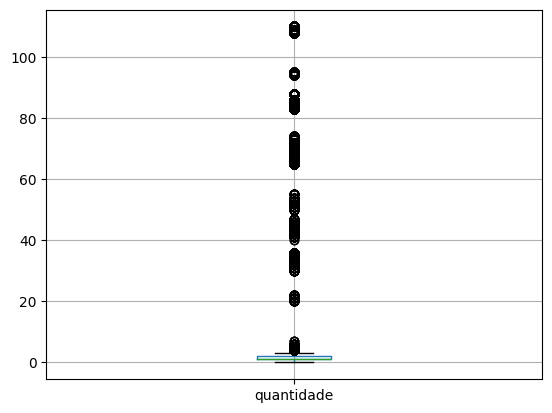

In [ ]:
df_final[['quantidade']].boxplot()

- Metodo score Z

In [ ]:
df_final['quantidade_z'] = scale(df_final['quantidade'])
df_final[['quantidade', 'quantidade_z']].sort_values('quantidade_z', ascending=False).head(10)

,quantidade,quantidade_z
27886,110.0,8.84404
20427,110.0,8.84404
22860,110.0,8.84404
22877,110.0,8.84404
22629,110.0,8.84404
22501,110.0,8.84404
19940,110.0,8.84404
25769,110.0,8.84404
25868,110.0,8.84404
19337,110.0,8.84404


In [ ]:
(df_final['quantidade_z'] > 3).sum()

np.int64(4762)

Em ambom os metodos conseguimos observar a existencia de varios outliers na coluna "quantidade", cerca de 4762 valores




---



2. É possivel identificar algo em relação às vendas associadas a estes outliers? Justifique sua resposta

In [ ]:
df_outliers = df_final[df_final['quantidade_z'] >= 3]

In [ ]:
total = df_outliers.shape[0]
df_ano = df_outliers['Ano'].value_counts().to_frame('n_outliers').reset_index()
df_ano.assign(perc = df_ano['n_outliers']/total)

,Ano,n_outliers,perc
0,2019,1545,0.324444
1,2020,1534,0.322134
2,2021,1471,0.308904
3,2022,212,0.044519


In [ ]:
total = df_final.shape[0]
df_ano_tot = df_final['Ano'].value_counts().to_frame('n').reset_index()
df_ano_tot.assign(perc = df_ano_tot['n']/total)

,Ano,n,perc
0,2022,50400,0.251014
1,2019,50283,0.250431
2,2020,50089,0.249465
3,2021,50014,0.249091


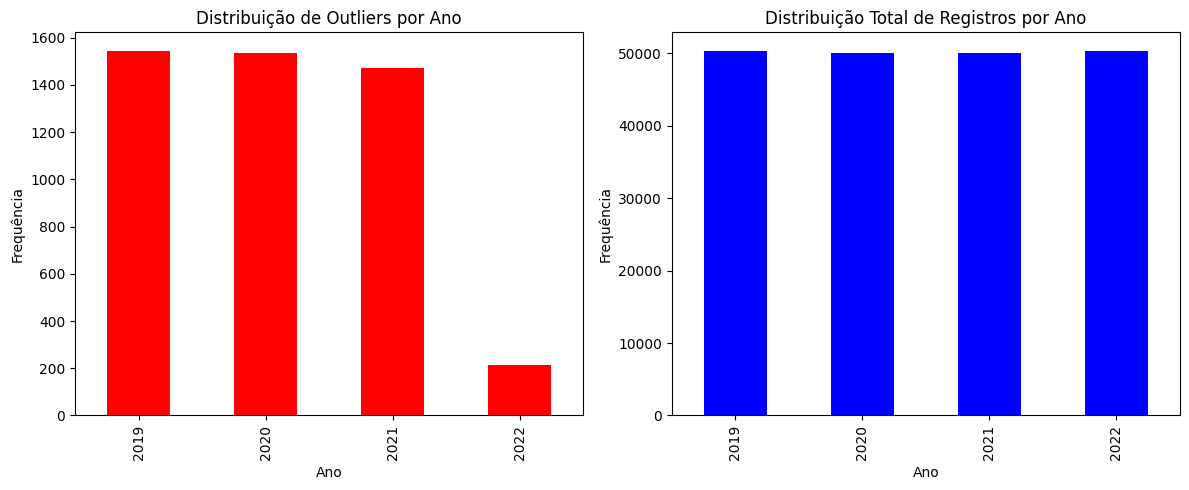

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))


df_outliers['Ano'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='red')
axes[0].set_title("Distribuição de Outliers por Ano")
axes[0].set_xlabel("Ano")
axes[0].set_ylabel("Frequência")


df_final['Ano'].value_counts().sort_index().plot(kind='bar', ax=axes[1], color='blue')
axes[1].set_title("Distribuição Total de Registros por Ano")
axes[1].set_xlabel("Ano")
axes[1].set_ylabel("Frequência")


plt.tight_layout()
plt.show()

De 2019 a 2021, a quantidade de dados outliers ficou mais ou menos a mesma. Mas em 2022, aconteceu algo: essa quantidade caiu drasticamente, sobrando só 4% dos dados outliers que tínhamos antes. A queda nos dados outliers em 2022 não foi por falta de dados, já que o total se manteve. Então, algo mudou nesse ano que fez os dados ficarem mais "normais".

---

3. Calcule uma estimativa de variabilidade que ignore o efeito desses outliers

- Tratando outliers com metodo winsorizar

In [ ]:
wins_values = df_final['quantidade'].quantile([0.05, 0.9]).to_list()
df_sem_otliers = df_final.assign(quantidade = df_final['quantidade'].clip(wins_values[0], wins_values[1]))
df_sem_otliers['quantidade'].head()

,quantidade
0,2.0
1,2.0
2,1.0
3,3.0
4,2.0


In [ ]:
df_sem_otliers['quantidade'].median()

1.0

---
---

## 3: Em relação a média de preço:

1. há diferença significativa entre a média de preço de alguma região e a média da população?

- Teste F

hipotese nula: não existe diferença significativamente estatisticamente entre as média de valore de cada região

In [ ]:
pg.anova(dv = 'valor',
         between = 'regiao_pais',
         data = df_final,
         detailed = True)

,Source,SS,DF,MS,F,p-unc,np2
0,regiao_pais,1.862834e+03,4,465.708448,0.01005,0.999801,2.002261e-07
1,Within,9.303650e+09,200781,46337.300754,NaN,NaN,NaN


p_value > 0.05 - Significa que falhamos em rejeitar hipotese nula, ou seja não existe diferença significativa entre o valor médio de cada região

Como não há diferença significativa entre as médias das regiões, podemos concluir que a média geral da população representa bem todas elas. Assim, não há necessidade de testes t individuais comparando cada região com a média geral, pois a ANOVA já indicou que essas médias são estatisticamente semelhantes.



---



2. Em relação á media de preço de alguma modalidade de pagamento e à media da população? Justifique a hipótese

- Teste F

Hipotese nula: Não existe diferença significativa entre as médias de preço das modalidades de pagamento.

In [ ]:
pg.anova(dv='valor',
         between='formapagto',
         data=df_final,
         )

,Source,ddof1,ddof2,F,p-unc,np2
0,formapagto,4,200781,0.991711,0.410514,0.00002


p_value > 0.05 - Significa que falhamos em rejeitar hipotese nula, ou seja não existe diferença significativa entre os preços médios das diferentes modalidades de pagamento.

Como não há diferença significativa entre os preços médios das diferentes modalidades de pagamento, podemos concluir que a média geral dos valores será próxima da média de cada modalidade. Assim, não há necessidade de testes adicionais comparando cada modalidade de pagamento com a média geral.



---

---

## 4: Calcule a matriz de correlação dos dados fornecidos.

In [ ]:
#Filtrar colunas
cols = ['valor', 'quantidade', 'valor_total_bruto', 'valor_comissao', 'lucro_liquido']

In [ ]:
#Criando matriz de correlação pearson
pearson = df_sem_otliers[cols].corr()
#Tornando vizualmente melhor
pearson.style.background_gradient(cmap='coolwarm').format('{:.2f}')

,valor,quantidade,valor_total_bruto,valor_comissao,lucro_liquido
valor,1.00,-0.11,0.06,0.21,0.19
quantidade,-0.11,1.00,0.04,0.09,0.17
valor_total_bruto,0.06,0.04,1.00,0.26,0.26
valor_comissao,0.21,0.09,0.26,1.00,0.89
lucro_liquido,0.19,0.17,0.26,0.89,1.00


1. Quais variáveis que apresentam forte correlação positiva ou negativa?

A unica correlação forte é apresentado pelas variaveis 'valor_comissao' e 'lucro liquido' com coeficiente de correlação pearson de 0.89. Isso indica uma forte correlação positiva, o que significa que quando o valor da comissão aumenta, o lucro líquido tende a aumentar na mesma proporção, e vice-versa

---

- Teste de hipotese

hipotese nula: Não há correlação entre as variaveis

In [ ]:
pg.pairwise_corr(df_sem_otliers,
                 columns=cols,
                 method='pearson')

,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,valor,quantidade,pearson,two-sided,200786,-0.109518,"[-0.11, -0.11]",0.000000e+00,inf,1.0
1,valor,valor_total_bruto,pearson,two-sided,200786,0.061934,"[0.06, 0.07]",7.908592e-170,1.012e+165,1.0
2,valor,valor_comissao,pearson,two-sided,200786,0.213175,"[0.21, 0.22]",0.000000e+00,inf,1.0
3,valor,lucro_liquido,pearson,two-sided,200786,0.191428,"[0.19, 0.2]",0.000000e+00,inf,1.0
4,quantidade,valor_total_bruto,pearson,two-sided,200786,0.036634,"[0.03, 0.04]",1.356976e-60,9.969e+55,1.0
5,quantidade,valor_comissao,pearson,two-sided,200786,0.085914,"[0.08, 0.09]",0.000000e+00,inf,1.0
6,quantidade,lucro_liquido,pearson,two-sided,200786,0.172221,"[0.17, 0.18]",0.000000e+00,inf,1.0
7,valor_total_bruto,valor_comissao,pearson,two-sided,200786,0.264349,"[0.26, 0.27]",0.000000e+00,inf,1.0
8,valor_total_bruto,lucro_liquido,pearson,two-sided,200786,0.262414,"[0.26, 0.27]",0.000000e+00,inf,1.0
9,valor_comissao,lucro_liquido,pearson,two-sided,200786,0.888694,"[0.89, 0.89]",0.000000e+00,inf,1.0


ao observar que todas as correlações têm p < 0.05, podemos rejeitar a hipotese nula e concluir que todas as correlações entre as variáveis testadas são estatisticamente significativas